<a href="https://colab.research.google.com/github/SunnieCoder/Machine-Learning-projects/blob/main/Deep%20Learning-based%20Audio%20Classification%20Model%20(Speech-to-Text).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn
!pip install torch torchvision torchaudio
!pip install librosa
!pip install tensorboard
!pip install torchmetrics

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import torch
import torchaudio
from torch import nn
import torch.optim as optim
from torch.optim import Adam
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_recall_fscore_support
from torchmetrics import Precision, Recall, F1Score
from sklearn.metrics import precision_score, recall_score, f1_score

Import dataset

In [ ]:
# Setting up the paths to the training, validation, and test audio files

train_audio_folder = '/WAVE/projects/CSEN-342-Wi24/data/pr3/train'
val_audio_folder = '/WAVE/projects/CSEN-342-Wi24/data/pr3/val'
test_audio_folder = '/WAVE/projects/CSEN-342-Wi24/data/pr3/test'

In [ ]:
# # Setting up the paths to the training, validation, and test audio files

# train_audio_folder = '/content/drive/My Drive/SCU - Deep learning - individual/Program 3/dataset/train'
# val_audio_folder = '/content/drive/My Drive/SCU - Deep learning - individual/Program 3/dataset/val'
# test_audio_folder = '/content/drive/My Drive/SCU - Deep learning - individual/Program 3/dataset/test'

In [ ]:
# This function reads the labels from a 'labels.txt' file, where each line corresponds to a label.
def load_labels(label_path):
    with open(label_path, 'r') as file:
        labels = [int(line.strip()) for line in file]
    return labels

In [ ]:
def get_audio_file_paths(audio_folder):
    file_paths = [f for f in os.listdir(audio_folder) if f.endswith('.wav')]
    file_paths.sort()  # Ensure the order is consistent
    return file_paths

Extract features

In [ ]:
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

In [ ]:
def get_melspectrogram_db(file_path, sr=28050, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav, sr = librosa.load(file_path, sr=sr)
  if len(wav.shape) == 2:
      wav = wav.mean(axis=1)
  if wav.shape[0]<5*sr:
      wav = np.pad(wav, int(np.ceil((5*sr-wav.shape[0])/2)), mode='reflect')
  else:
      wav = wav[:5*sr]
  spec = librosa.feature.melspectrogram(y=wav, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmin=fmin, fmax=fmax)
  spec_db = librosa.power_to_db(spec, top_db=top_db)
  return spec_db

In [ ]:
sample = '/WAVE/projects/CSEN-342-Wi24/data/pr3/train/00348.wav'

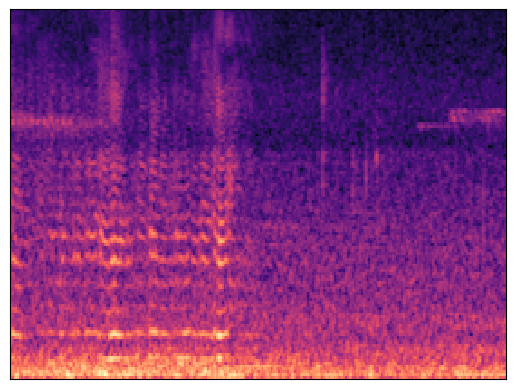

In [ ]:
librosa.display.specshow(spec_to_image(get_melspectrogram_db(sample)))

In [ ]:
class ProcessData(Dataset):
    def __init__(self, base, file_paths, labels=None):
        self.base = base
        self.file_paths = file_paths
        self.labels = labels

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = os.path.join(self.base, self.file_paths[idx])
        spec_img = spec_to_image(get_melspectrogram_db(file_path))
        if self.labels is not None:
            label = self.labels[idx]
            return spec_img[np.newaxis, ...], label
        else:
            # For test set, where there are no labels
            return spec_img[np.newaxis, ...]

Create Datasets and DataLoaders

In [ ]:
train_label_path = os.path.join(train_audio_folder, 'labels.txt')
val_label_path = os.path.join(val_audio_folder, 'labels.txt')

# Load labels
train_labels = load_labels(train_label_path)
val_labels = load_labels(val_label_path)

In [ ]:
# Get file paths
train_files = get_audio_file_paths(train_audio_folder)
val_files = get_audio_file_paths(val_audio_folder)
test_files = get_audio_file_paths(test_audio_folder)

In [ ]:
# Create Dataset objects
train_data = ProcessData(train_audio_folder, train_files, train_labels)
valid_data = ProcessData(val_audio_folder, val_files, val_labels)
test_data = ProcessData(test_audio_folder, test_files)  # No labels for test data

In [ ]:
len(train_data)

350

In [ ]:
# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)  # No shuffling needed for test data

In [ ]:
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')

Build the NeuralNetwork

In [ ]:
class CRNNModel(nn.Module):
    def __init__(self, num_cats=26):
        super(CRNNModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn8 = nn.BatchNorm2d(256)

        # Linear layer
        self.linear = nn.Linear(256, 1024)

        # RNN layers
        self.hidden_size = 128
        self.num_layers = 2
        self.dropout_prob = 0.5
        self.rnn = nn.LSTM(1024, self.hidden_size, self.num_layers, batch_first=True, dropout=self.dropout_prob)

        # Fully connected layers
        self.dense1 = nn.Linear(self.hidden_size, 500)
        self.dropout = nn.Dropout(0.5)
        self.dense2 = nn.Linear(500, num_cats)

    def forward(self, x):
        # Pass data through convolutional layers with ReLU activations and BatchNorm
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = F.max_pool2d(x, kernel_size=2)

        # Flatten the output for the LSTM layers
        batch_size, channels, height, width = x.size()
        num_features = channels * height  # Features for each time step in the sequence
        x = x.view(batch_size, width, num_features)  # Reshape to [batch, seq_len, features]

        # LSTM layers
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        # Pass data through RNN layers
        out, _ = self.rnn(x, (h0, c0))

        # Take the output for the last time step
        out = out[:, -1, :]

        # Pass the output of the RNN to the final dense layers
        out = self.dropout(F.relu(self.dense1(out)))
        out = self.dense2(out)

        return out

Instantiate the Model and Define Optimizer

In [ ]:
def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)
    return precision, recall, f1

In [ ]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

def lr_decay(optimizer, epoch):
    if epoch % 20 == 0:
        new_lr = learning_rate / (10 ** (epoch // 20))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer

In [ ]:
model = CRNNModel(num_cats=26).to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
epochs = 60

Train the model

In [ ]:
# Set up TensorBoard
writer = SummaryWriter('/WAVE/users/unix/wmo/Desktop/p3runs')

In [ ]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, change_lr=None):
    for epoch in range(1, epochs + 1):
        model.train()
        batch_losses = []
        y_true_train = []
        y_pred_train = []

        if change_lr:
            optimizer = change_lr(optimizer, epoch)

        for i, data in enumerate(train_loader):
            x, y = data
            optimizer.zero_grad()
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            # x = x.squeeze(1)
            # # print(x.shape)

            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
            _, predicted = torch.max(y_hat, 1)
            y_true_train += y.cpu().tolist()
            y_pred_train += predicted.cpu().tolist()

        # Calculate training metrics
        precision_train, recall_train, f1_train = calculate_metrics(y_true_train, y_pred_train)
        train_loss = np.mean(batch_losses)

        # Log training metrics
        writer.add_scalar('Training Loss', train_loss, epoch)
        writer.add_scalar('Training Precision', precision_train, epoch)
        writer.add_scalar('Training Recall', recall_train, epoch)
        writer.add_scalar('Training F1 Score', f1_train, epoch)

        model.eval()
        valid_losses = []
        y_true_valid = []
        y_pred_valid = []

        with torch.no_grad():
            for i, data in enumerate(valid_loader):
                x, y = data
                x = x.to(device, dtype=torch.float32)
                y = y.to(device, dtype=torch.long)
                # x = x.squeeze(1)

                y_hat = model(x)
                loss = loss_fn(y_hat, y)
                valid_losses.append(loss.item())
                _, predicted = torch.max(y_hat, 1)
                y_true_valid += y.cpu().tolist()
                y_pred_valid += predicted.cpu().tolist()

        # Calculate validation metrics
        precision_valid, recall_valid, f1_valid = calculate_metrics(y_true_valid, y_pred_valid)
        valid_loss = np.mean(valid_losses)

        # Log validation metrics
        writer.add_scalar('Validation Loss', valid_loss, epoch)
        writer.add_scalar('Validation Precision', precision_valid, epoch)
        writer.add_scalar('Validation Recall', recall_valid, epoch)
        writer.add_scalar('Validation F1 Score', f1_valid, epoch)

        # Print epoch summary
        print(f'Epoch - {epoch} Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')
        print(f'Training Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1 Score: {f1_train:.4f}')
        print(f'Validation Precision: {precision_valid:.4f}, Recall: {recall_valid:.4f}, F1 Score: {f1_valid:.4f}')


In [ ]:
# Call the train function
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, lr_decay)

# Close the SummaryWriter
writer.close()

Run the monitor

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir '/content/drive/My Drive/SCU - Deep learning - individual/Program 3/runs'

Save the model

In [ ]:
model_save_path = '/WAVE/users/unix/wmo/Desktop/p3runs/model1.pth'

In [ ]:
torch.save(model, model_save_path)

Load the model

In [ ]:
# # Load path
# model_load_path = '/content/drive/My Drive/SCU - Deep learning - individual/Program 3/model.pth'

In [ ]:
model_load_path = '/WAVE/users/unix/wmo/Desktop/p3runs/model1.pth'

In [ ]:
load_model = torch.load(model_load_path)

Prediction

In [ ]:
def predict(load_model, test_loader):
    load_model.eval()  # Set model to evaluate mode
    predictions = []
    for inputs in test_loader:
        with torch.no_grad():
            inputs = inputs.to(device, dtype=torch.float32)
            # inputs = inputs.squeeze(1)
            outputs = load_model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().tolist())
    return predictions

In [ ]:
predictions = predict(load_model, test_loader)

Export the predictions file

In [ ]:
# Define the file path
# file_path = '/content/drive/My Drive/SCU - Deep learning - individual/Program 3/predictions.txt'

output_file_path = '/WAVE/users/unix/wmo/Desktop/p3runs/predictions.txt'

# Write the predictions to the output file
with open(output_file_path, 'w') as f:
    for item in predictions:
        f.write("%s\n" % item)

# Return the file path for the user to download
output_file_path